## Intro
As a newly hired machine learning (ML) engineer, you have been tasked with improving 'Cat-titude Enhancer 2000,' a product that utilizes technology to monitor and enhance the well-being of cats through a play gym. The system operates by continuously streaming video footage from a camera installed in the gym, which provides input to your ML model. Based on this data, your system generates an overall recommended recipe with specific calorie counts for the cat to promote happiness, health, and strength.

## Objectives
You only deal with certain specifc backend tasks. These are your high level objectives.
1. Improve cat image classification system. The initial cat classification model was not trained properly and this lead to some complaints from your senior ML engineer.
2. Find a good threshold for cat image classification system. Earlier version of the model detected cat when there were none, the system ended up recommending that the cat be fed more food. Our product is being accused of producing fat cats. We must do something about it.
3. Develop the prototype to take a 'glamour shot' of the cat with a still frame with blurred background. We get internet points if we take an amazing shot of the cat from the video and send it to owner.


We will be using real world data, so your solutions will not be perfect. You will get full mark as long as you prove that you are capable of implementing solutions that uses the computer vision techniques and justify your answers in the context of what is asked.

## Questions
On to assignment proper. Your tasks are:
1. Your predecessor build a training algorithm that just trained for a random number of epochs and assumed that it was the best model. Build an early stopping system for this training, ie, find the number of epochs to train, when the value of a selected quality metric is maximized. Choose an appropriate metric and justify your explanation. [10 marks]


This is the code written by your predecessor.

In [1]:
# Install touch and touch vision

!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

/tmp/ipykernel_11491/492679038.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Download and load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include images of cats (class 3) and another class (e.g., class 0)
dataset = [(img, label) for img, label in dataset if label in [0, 3]]
trainset = dataset
# Make dataloader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Load the pre-trained MobileNetV2 model and modify last layer
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model and track metrics with MLflow
softmax = nn.Softmax(dim=1)
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))  # convert labels to 0/1
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)

        # print("outputs.shape >> ", outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 156 == 155:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 156))
            running_loss = 0.0
best_model = model
THRESHOLD = 0.1

Files already downloaded and verified


/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   156] loss: 0.241
[2,   156] loss: 0.109


The metric to be utilized for early stopping is the validation loss. As the validation loss begins to deteriorate, the training process is halted after reaching a certain level of patience.

In [3]:
## Your code here

# Download and load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include images of cats (class 3) and another class (e.g., class 0)
dataset = [(img, label) for img, label in dataset if label in [0, 3]]
trainset = dataset

# Split dataset into training and validation sets
#Validation set is used to calculate early stoppage
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Initialize variables for early stopping
#starts validation loss at infinity
best_val_loss = float('inf')

# Patience represents the number of epochs to wait 
# before stopping training when the validation loss does not improve
patience = 5
counter = 0

# Load the pre-trained MobileNetV2 model and modify last layer
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Save best model
best_model = model

# Train the model and track metrics with early stopping
# Maximum number of epoch is 100
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # convert labels to 0/1
        labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # print every 125 mini-batches (basically print once every epoch)
        if i % 125 == 124:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
    
    # Validate the model after each epoch
    val_loss = 0.0
    with torch.no_grad(): # Don't compute gradient for this operation
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_labels = torch.where(val_labels==3, torch.tensor([1]), torch.tensor([0]))
            
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
    
            
    print('[Epoch %d] Validation Loss: %.3f' % (epoch + 1, val_loss))
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        best_model = model  # Update the best model
    else:
        counter += 1  # Increment counter if validation loss does not improve
    
    print('counter >> ', counter)
    # Check if early stopping criteria met
    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

Files already downloaded and verified
[1,   125] loss: 31.649
[Epoch 1] Validation Loss: 5.147
counter >>  0
[2,   125] loss: 13.956
[Epoch 2] Validation Loss: 5.593
counter >>  1
[3,   125] loss: 11.299
[Epoch 3] Validation Loss: 4.893
counter >>  0
[4,   125] loss: 8.316
[Epoch 4] Validation Loss: 4.804
counter >>  0
[5,   125] loss: 5.463
[Epoch 5] Validation Loss: 5.012
counter >>  1
[6,   125] loss: 3.912
[Epoch 6] Validation Loss: 5.471
counter >>  2
[7,   125] loss: 3.437
[Epoch 7] Validation Loss: 5.501
counter >>  3
[8,   125] loss: 2.722
[Epoch 8] Validation Loss: 5.391
counter >>  4
[9,   125] loss: 2.606
[Epoch 9] Validation Loss: 5.718
counter >>  5
Early stopping triggered. Stopping training.


In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

softmax = nn.Softmax(dim=1)

# Compute training outputs and labels using the best model
# best_training_outputs = []
# training_labels = []
# for inputs, labels in train_loader:
#     outputs = best_model(inputs)
#     best_training_outputs.append(outputs)
#     training_labels.append(labels)

# Compute validation outputs and labels using the best model
best_validation_outputs = []
validation_labels = []
for inputs, labels in val_loader:
    outputs = best_model(inputs)
    labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))
    best_validation_outputs.append(outputs)
    validation_labels.extend(labels)

best_validation_outputs_tensor = torch.cat(best_validation_outputs, dim=0)


probabilities = softmax(best_validation_outputs_tensor).detach().numpy()
labels = np.array(validation_labels)


print(probabilities.shape)
print(labels.shape)





(2000, 2)
(2000,)


In [12]:
fpr, tpr, thresholds = roc_curve(labels, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Find the best threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [13]:
optimal_threshold

0.15766805

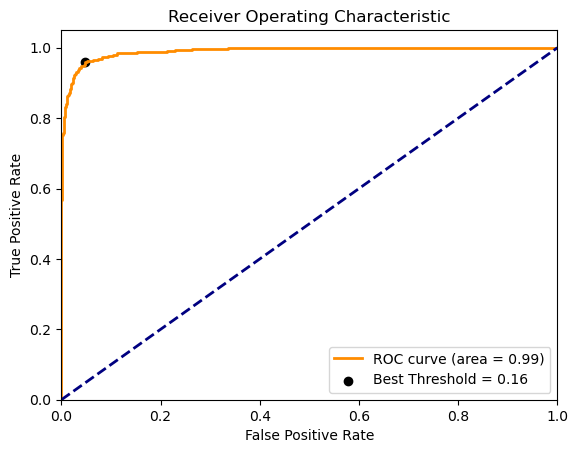

In [14]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold = %0.2f' % optimal_threshold)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

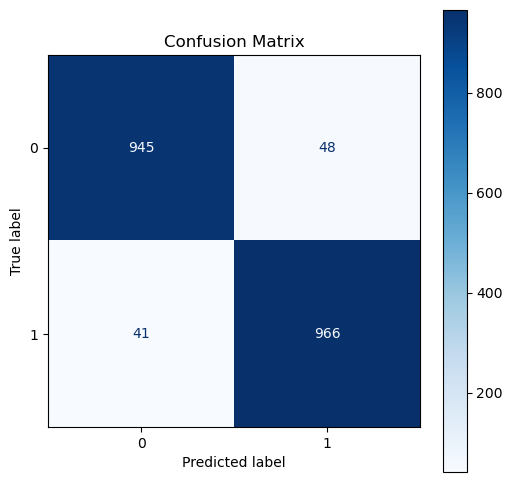

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (probabilities[:, 1] >= optimal_threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(labels, y_pred)

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


In [6]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# softmax = nn.Softmax(dim=1)

# # Compute training outputs and labels using the best model
# best_training_outputs = []
# training_labels = []
# for inputs, labels in train_loader:
#     outputs = best_model(inputs)
#     best_training_outputs.append(outputs)
#     training_labels.append(labels)

# # Compute validation outputs and labels using the best model
# best_validation_outputs = []
# validation_labels = []
# for inputs, labels in val_loader:
#     outputs = best_model(inputs)
#     best_validation_outputs.append(outputs)
#     validation_labels.append(labels)


# print(best_training_outputs[0].shape)
# best_training_outputs_tensor = torch.cat(best_training_outputs, dim=0)

# print(best_training_outputs_tensor.shape)

# probabilities = softmax(best_training_outputs_tensor)

# # Convert probabilities to predicted labels using threshold
# predicted_labels = (probabilities[:, 1] > THRESHOLD).int()

# # Convert training labels and predicted labels to NumPy arrays
# training_labels_np = torch.tensor(training_labels).flatten().numpy()
# predicted_labels_np = predicted_labels.flatten().numpy()

# # Compute confusion matrix
# conf_matrix = confusion_matrix(training_labels_np, predicted_labels_np)

# # Plot confusion matrix using seaborn heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title(f'Confusion Matrix - Training Set (Threshold={THRESHOLD})')
# plt.show()

: 

In [31]:
# Your code here
for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    if i == 0:
        print(len(inputs[0]))

    labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))

    outputs = best_model(inputs)
    loss = criterion(outputs, labels)

loss.item()

#0.1478763073682785  epoch 2
#0.07189879566431046 epoch 20

3


0.04774435609579086

2. Compute a threshold that meets the objectives of the larger task. Explain your reasoning clearly. This is an open question, but there are certain range of metrics that makes sense here. [5 marks]

In [ ]:
# Your code here

print(f"New threshold is {THRESHOLD}")

3. Build a cat photo capture system that stores the best image of the cat and blurs the background. We provided you with a randomly picked sample video.

  For this assignment, we will define the best image as the one in which the cat occupies the most area on screen. So your objectives are
    1. Iterate through every frame of video, use the classifer you trained with the threshold you designed to count the number of frames in which there is a cat. `[5 marks]`
    2. If a cat is detected, segment the cat and enhance the image. The enhanced image could have either (do one of these).  `[15 marks]`
      - Blurred background background. Use `GaussianBlur` function in opencv to achieve the blur effect.
      - White background.      
    3. Figure out a logic to find out the frame in which the cat occupies most area and save/display that image. The file name of that should be `cat_<current_time>_<number_of_frames>.jpg`. `[5 marks]`

Notes and hints
- The results here need not be perfect, you will have blurred image of the cat because of motion in the video. For the scope of this assignment, motion blur in the image is acceptable.
- Use maskRCNN.
- Use pretrained model from torch vision.  
- Video itself is long, but for experimentation first 50 frames will be enough to get you some good samples of cats.
- Try `sample_video2.mp4` first, then `sample_video.mp4`.
- The videos are provided for educationl use only, from https://www.pexels.com/search/videos/cat%20jump/. Please donot redistrubute the sample videos.

Here is some sample code to read the video file to get you started.

In [3]:
import os

# The code below minimizes the amount of downloads when you rerun all cells.
# You probably don't need to download the same file over and over again...
if os.path.isfile('sample_video2.mp4'):
    print('File already exists! Delete the file to force download again...')
else:
    !wget -O sample_video2.mp4 'https://docs.google.com/uc?export=download&id=1wQDX5uu56NOLVPXQtngjeA4Cy5gygd_6&confirm=t'

if os.path.isfile('sample_video.mp4'):
    print('File already exists! Delete the file to force download again...')
else:
    !wget -O sample_video.mp4 'https://docs.google.com/uc?export=download&id=1mkAjevnCeZDefXrDIu9N-2qIxDngPbL0&confirm=t'


File already exists! Delete the file to force download again...
--2024-03-07 00:49:19--  https://docs.google.com/uc?export=download&id=1mkAjevnCeZDefXrDIu9N-2qIxDngPbL0&confirm=t
Resolving docs.google.com (docs.google.com)... 142.251.2.102, 142.251.2.139, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mkAjevnCeZDefXrDIu9N-2qIxDngPbL0&export=download [following]
--2024-03-07 00:49:19--  https://drive.usercontent.google.com/download?id=1mkAjevnCeZDefXrDIu9N-2qIxDngPbL0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428 (2.4K) [text/html]
Saving to: ‘sample_video.mp4’

sample_video.

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

TOTAL_FRAME_LIMIT = 2
framecount = 0

def blur_background(image, mask):
    out_image = image
    # your code here
    return out_image

# your model set up code here

# Read sample file and process
cap = cv2.VideoCapture("sample_video2.mp4")
if not cap.isOpened():
    print("Error opening video file")
    exit(1)

def process_frame(frame):
    best_image = frame
    best_mask = None
    # single image processing code here
    return best_image, best_mask

print("Processing frames...")
for totalframe in tqdm(range(TOTAL_FRAME_LIMIT)):
    framecount += 1
    ret, frame = cap.read()
    if ret:
        best_image, best_mask= process_frame(frame)
    else:
        break

best_image = blur_background(best_image, best_mask)
best_image = cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB)
plt.imshow(best_image)
plt.title(f"cat_{datetime.datetime.now()}_{framecount}.jpg")
plt.show()

Extra tasks if you are interested
- Make this real time.  
- Use image quality metric to take the frame with the best image of the cat
- Improve segmentation with Segment anything model.